In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import requests
from bs4 import BeautifulSoup

In [153]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 \
                   (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}

url = "https://housing.com/rent/flats-for-rent-in-hyderabad-telangana-P679xe73u28050522"
response = requests.get(url, headers=headers)
print(response.status_code)

200


In [154]:
page=requests.get(url)
pagecontent=page.text
soup = BeautifulSoup(pagecontent)

<!DOCTYPE html>
<html lang="en" prefix="og: http://ogp.me/ns# website: http://ogp.me/ns/website#"><head><link href="//c.housingcdn.com" rel="preconnect"/><link href="//is1-3.housingcdn.com" rel="preconnect"/><link href="//eventrouter.housing.com" rel="preconnect"/><link href="//img.youtube.com" rel="preconnect"/><link href="//is1-2.housingcdn.com" rel="preconnect"/><link href="//housing-images.n7net.in" rel="preconnect"/><meta content="AsgGWjPX2xx12aBpNxa8enFVy/0d/Ghc/GLjQO1gdmgn6eayydZJK0TGTifjIngm+7B4rWjfgVoyHZFbeKq0pg4AAABgeyJvcmlnaW4iOiJodHRwczovL2hvdXNpbmcuY29tOjQ0MyIsImZlYXR1cmUiOiJXYWtlTG9jayIsImV4cGlyeSI6MTU5MTA5NTk2MSwiaXNTdWJkb21haW4iOnRydWV9" http-equiv="origin-trial"/><meta content="no-referrer-when-downgrade" name="referrer"/><link as="image" href="//c.housingcdn.com/demand/s/client/common/assets/loader.fd27d2ce.svg" rel="prefetch"/><link as="font" crossorigin="anonymous" href="//c.housingcdn.com/demand/s/client/common/assets/style.24e9b99c.woff2" rel="preload"/><link as="
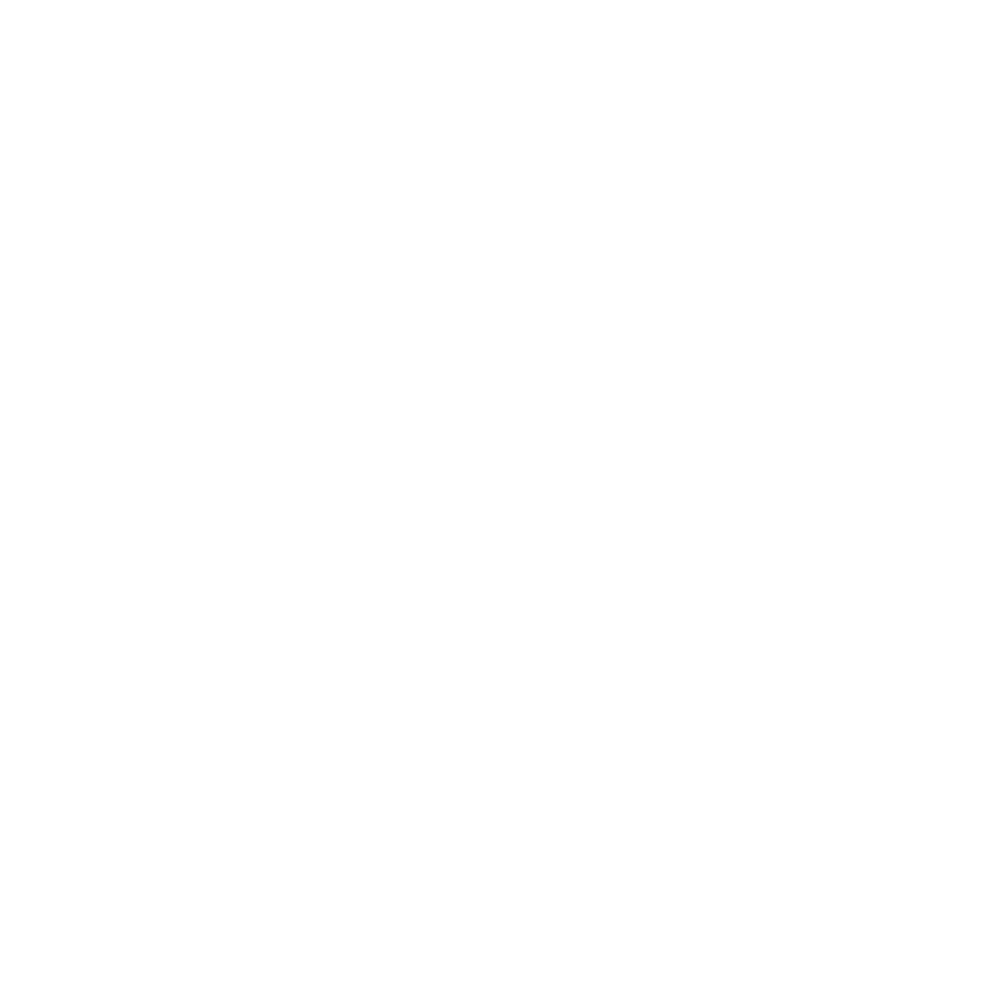

In [155]:
soup

In [321]:
ID = []
Location = []
BHK = []
Price = []
Furnishing_Status = []
Amenities = []
Sq_ft = []
Brokerage = []
Maintenance = []
Rating = []

base_url = "https://housing.com"
id_counter = 1  # starting ID

for i in range(1, 15):
    url = f'https://housing.com/rent/flats-for-rent-in-hyderabad-telangana-P679xe73u28050522?page={i}'
    page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.text, 'html.parser')

    for x in soup.find_all('div', attrs={'class': "infoTopContainer"}):
        location = x.find('div', attrs={'class': "T_arrangeElementsSpaceBetween _cxftgi _0h1h6o _fc1yb4 _9s1txw"})
        bhk = x.find('div', attrs={'class': "T_arrangeElementsSpaceBetween _cxftgi _0h1h6o _fc1yb4 _9s1txw"})
        rental_price = x.find('div', attrs={'class': "T_singlePriceStyle _7l1ulh _r31e5h _g3gktf _csbfng _c8exct _bx1t02", 'data-q': "price"})
        sq_ft = x.find('div', attrs={'class': "T_primaryInfoTextStyle _t9glyw _c81fwx T_descriptionStyle _7l1472 _r31e5h _g3exct _csbfng _bx1t02"})

        # Get inside page link
        link_tag = x.find('a', href=True)
        if link_tag:
            inside_url = base_url + link_tag['href']
            
            inner_resp = requests.get(inside_url, headers={'User-Agent': 'Mozilla/5.0'})
            inner_soup = BeautifulSoup(inner_resp.text, 'html.parser')

            brokerage = inner_soup.find('div', attrs={'class': "_h3i2wt T_valueStyle"})
            brokerage = brokerage.find_next('div').get_text(strip=True) if brokerage else None

            maintenance_val = inner_soup.find('div', attrs={'span': "_h3i2wt T_valueStyle"})
            maintenance_val = maintenance_val.find_next('div').get_text(strip=True) if maintenance_val else None

            amenities_list = [a.get_text(strip=True) for a in inner_soup.find_all('div', {'class': 'T_cellStyle _1wbo1osq _5jftgi _3f1aa9 _l8edxx _e2u29b cell'})]

            furnishing_status = [a.get_text(strip=True) for a in inner_soup.find_all('div', {'class': "_h3i2wt T_valueStyle"})]

            rating_tag = inner_soup.find('span', class_="_csbfng _c8dlk8 _7l1qmd _h0yh40 _1q733bzg _4okucf5i T_avgRatingStyle")
            rating = rating_tag.get_text(strip=True) if rating_tag else None
        else:
            brokerage = None
            maintenance_val = None
            amenities_list = None
            rating = None
            
        # Append unique ID
        ID.append(id_counter)
        id_counter += 1

        # Append scraped data
        Location.append(location.text if location else np.nan)
        BHK.append(bhk.text if bhk else np.nan)
        Price.append(rental_price.text if rental_price else np.nan)
        Amenities.append(", ".join(amenities_list) if amenities_list else np.nan)
        Furnishing_Status.append(", ".join(furnishing_status) if furnishing_status else np.nan)
        Sq_ft.append(sq_ft.text if sq_ft else np.nan)
        Brokerage.append(brokerage if brokerage else np.nan)
        Maintenance.append(maintenance_val if maintenance_val else np.nan)
        Rating.append(rating if rating else np.nan)


In [369]:
df={'House_ID':ID,
'Location' : Location,
'BHK' : BHK,
'Price' : Price,
'Furnishing_Status':Furnishing_Status,
'Amenities': Amenities,
'Sq_ft' : Sq_ft,
'Brokerage' : Brokerage,
'Maintenance' : Maintenance,
'Rating':Rating}

In [370]:
df=pd.DataFrame(df)

In [371]:
df['Location'] = df['Location'].apply(lambda x: re.findall(r'in\s+(.+)$', x)[0] if re.findall(r'in\s+(.+)$', x) else None)

In [372]:
df['BHK'] = df['BHK'].apply(
    lambda x: re.findall(r'\d+(?:\.\d+)?\s*BHK', x)[0] if re.findall(r'\d+(?:\.\d+)?\s*BHK', x) else None)


In [373]:
df['Sq_ft'] = (
    df['Sq_ft']
    .str.replace('sq.ft', '', regex=False)  # remove "sq.ft"
    .str.replace(',', '', regex=False)      # remove commas
    .str.strip()                             # remove extra spaces
    .astype(float)                           # convert to numeric
)

In [374]:
df['Price'] = df['Price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False).astype(float)

In [375]:

df['Furnishing'] = df['Furnishing_Status'].apply(
    lambda x: re.search(r'(Semi Furnished|Fully Furnished|Unfurnished)', x).group(0) if pd.notnull(x) and re.search(r'(Semi Furnished|Fully Furnished|Unfurnished)', x) else None
)

In [376]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

In [377]:
df['Brokerage'] = (df['Brokerage'].str.replace(',', '', regex=False).str.strip())   
df['Brokerage'] = pd.to_numeric(df['Brokerage'], errors='coerce')

In [378]:
def extract_maintenance(text):
    if pd.isna(text):
        return None
    # Find all numbers with optional commas
    nums = re.findall(r'\d[\d,]*', text)
    if len(nums) >= 3:
        return nums[2].replace(',', '')  # Remove commas and return
    return None

df['Maintenance'] = df['Furnishing_Status'].apply(extract_maintenance)

In [379]:
results = []

for i in range(0, 10):
    nums = re.findall(r'\d[\d,]*', str(df['Furnishing_Status'][i]))
    if len(nums) >= 4:  # ensure at least 4 numbers exist
        results.append(int(nums[3].replace(',', '')))  # store 4th number
    else:
        results.append(None)  # store None if not found

df1 = pd.DataFrame(results, columns=['Fourth_Number'])
a=df1['Fourth_Number'].mean()


In [380]:
df['Maintenance'] = df['Maintenance'].fillna(a)

In [381]:
df['Maintenance'] = pd.to_numeric(df['Maintenance'], errors='coerce')

In [382]:
df.loc[df['Maintenance'] == df['Brokerage'], 'Maintenance'] = np.nan

In [383]:
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())

In [384]:
df['Maintenance'] = pd.to_numeric(df['Maintenance'], errors='coerce')

In [386]:
df['Maintenance'] = df['Maintenance'].fillna(df['Maintenance'].mean())
df['Maintenance'] = df['Maintenance'].round(0).astype(float)

In [391]:
df['BHK'] = df['BHK'].fillna('1 BHK')

In [419]:
most_common_amenities = df['Amenities'].mode()[0]
df['Amenities'] = df['Amenities'].fillna(most_common_amenities)

In [430]:
df['Brokerage'] = df['Brokerage'].fillna(df['Brokerage'].mean())

In [7]:
df.head(5)

,Unnamed: 0,Location,BHK,Price,Amenities,Sq_ft,Brokerage,Maintenance,Rating,Furnishing
0,0,Narsingi,4.0,80000,"Microwave, Stove, Gas Pipeline, Cupboard, 7Fan...",3380,80000.0,1291,4.3,Semi Furnished
1,1,Narsingi,2.0,50003,"Gas Pipeline, Cupboard, 6Fan, 8Light, 2Wardrob...",1370,50003.0,5000,4.5,Semi Furnished
2,2,Serilingampally,2.5,65000,"Gas Pipeline, Cupboard, 6Fan, 36Light, 1Wardro...",1490,32500.0,1291,4.8,Semi Furnished
3,3,Madhapur,2.0,38000,"Washing Machine, Sofa, Stove, Fridge, Water Pu...",1350,38000.0,2000,4.6,Fully Furnished
4,4,Kondapur,1.0,24500,"Washing Machine, Sofa, Fridge, Cupboard, 2Fan,...",750,24500.0,750,4.8,Fully Furnished


In [2]:
df=pd.read_csv("Flat_Rent_Hyd_Analysis_cleaned.csv")

In [4]:
df['BHK'] = df['BHK'].str.extract(r'(\d+\.?\d*)').astype(float)

In [5]:
df = df.drop(columns='Furnishing_Status')

In [6]:
df = df.drop(columns=['House_ID'],axis=1)

In [159]:
df.describe()

,Unnamed: 0,BHK,Price,Sq_ft,Brokerage,Maintenance,Rating
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,209.500000,2.860714,76712.828571,2487.419048,52534.689751,1290.964286,4.481220
std,121.387808,0.718162,73788.817466,1481.547889,17342.961981,942.826744,0.359745
min,0.000000,1.000000,16000.000000,500.000000,8000.000000,1.000000,1.000000
25%,104.750000,2.500000,45014.000000,1697.000000,45008.250000,1291.000000,4.300000
50%,209.500000,3.000000,60000.000000,2178.000000,52534.689750,1291.000000,4.500000
75%,314.250000,3.000000,70000.000000,2655.000000,62261.250000,1291.000000,4.625000
max,419.000000,5.000000,450015.000000,9166.000000,90014.000000,12000.000000,5.000000


In [439]:
df[df.columns].count()                                     #checking for nan in all coloumns

House_ID             420
Location             420
BHK                  420
Price                420
Furnishing_Status    420
Amenities            420
Sq_ft                420
Brokerage            420
Maintenance          420
Rating               420
Furnishing           420
dtype: int64

In [443]:
df.dtypes.reset_index(name='DataType').rename(columns={'index': 'Column'})

,Column,DataType
0,House_ID,int64
1,Location,object
2,BHK,object
3,Price,float64
4,Furnishing_Status,object
5,Amenities,object
6,Sq_ft,float64
7,Brokerage,float64
8,Maintenance,float64
9,Rating,float64


In [447]:
df.to_csv("Flat_Rent_Hyd_Analysis_cleaned.csv")

In [121]:
df

BHK
3.0    215
2.0     75
4.0     60
2.5     44
1.0     16
3.5      5
4.5      4
5.0      1
Name: count, dtype: int64

#### Problem

### 1. which areas has the highest no of flats in 2025?

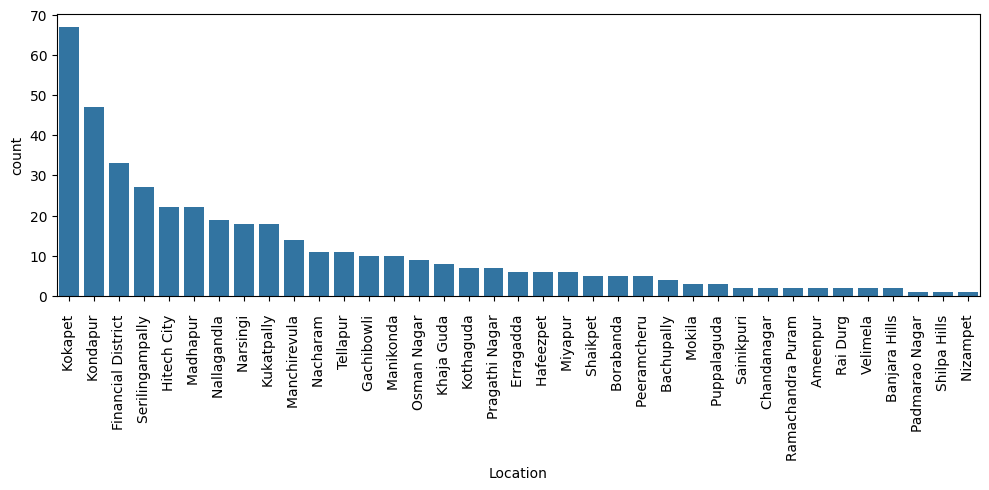

In [480]:
plt.figure(figsize=(10,5))
sns.countplot(x='Location', data=df, order=df['Location'].value_counts().index)
plt.xticks(rotation=90)  # rotate labels for readability
plt.tight_layout()
plt.show()

### kokapet,kondapur,financial district,serillingampally, Hitech city,Madhapur has the highest flats in Hyderabad

### 2. In each location has avg BHK and price

In [191]:
top5 = df.groupby('Location')['Price'].mean().head(6)

top5

Location
Ameenpur           26000.000000
Bachupally         35002.500000
Banjara Hills      70000.000000
Borabanda          57002.200000
Chandanagar        38000.000000
Erragadda          52004.333333
Name: Price, dtype: float64

C:\Users\palla\AppData\Local\Temp\ipykernel_50148\1725064057.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Location', y='Price', data=df.head(10), palette='viridis')


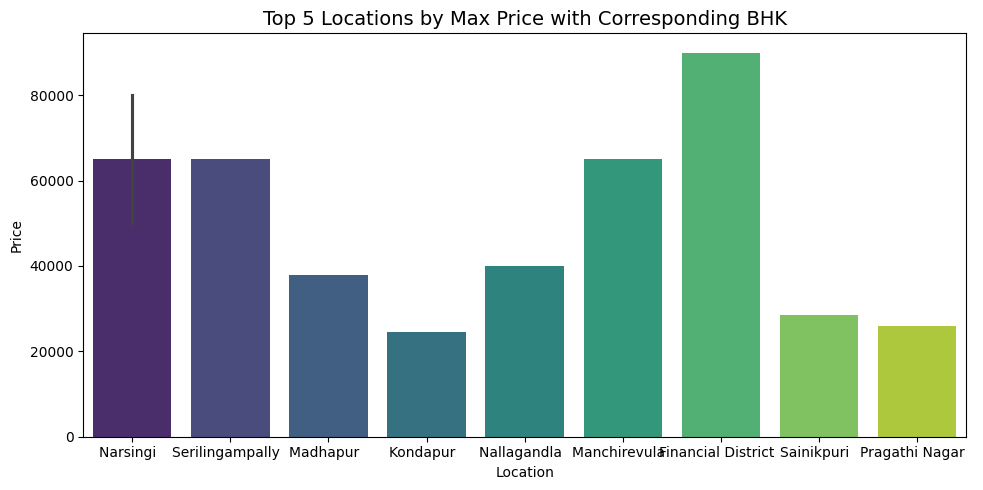

In [194]:
plt.figure(figsize=(10,5))
sns.barplot(x='Location', y='Price', data=df.head(10), palette='viridis')
plt.title('Top 5 Locations by Max Price with Corresponding BHK', fontsize=14)
plt.ylabel('Price')
plt.xlabel('Location')
plt.tight_layout()
plt.show()


### 3. What is the distribution of rental prices across the city?

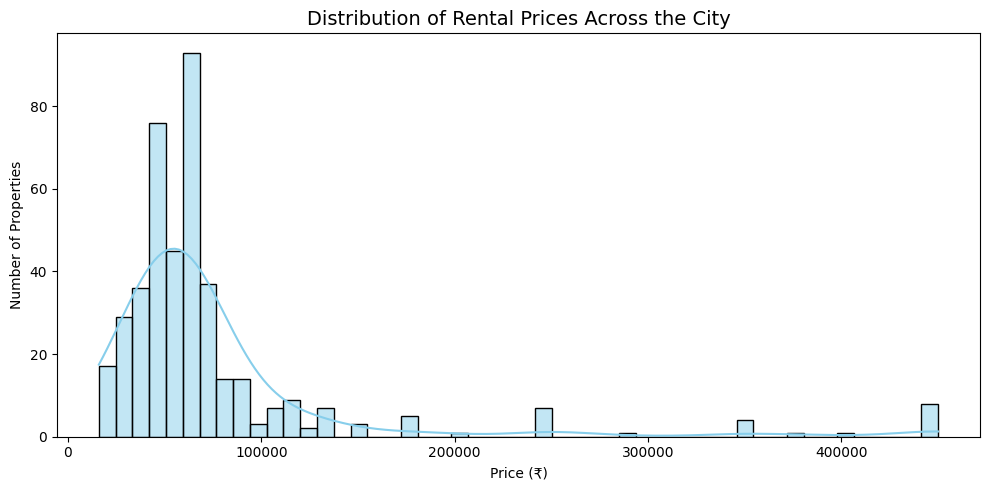

In [14]:

plt.figure(figsize=(10,5))

# Histogram with KDE overlay
sns.histplot(df['Price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Rental Prices Across the City', fontsize=14)
plt.xlabel('Price (₹)')
plt.ylabel('Number of Properties')
plt.tight_layout()
plt.show()

#### 4.Which furnishing type (Fully / Semi / Unfurnished) is most common?

In [35]:
fur_count= df['Furnishing'].value_counts()
fur_count

Furnishing
Semi Furnished     322
Fully Furnished     95
Unfurnished          3
Name: count, dtype: int64

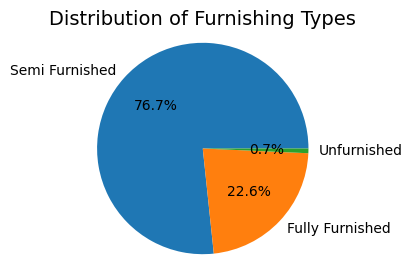

In [38]:
plt.figure(figsize=(3,3))
plt.pie(fur_count,labels = fur_count.index,autopct='%1.1f%%') 
plt.title('Distribution of Furnishing Types', fontsize=14)
plt.axis('equal')  # Keeps the pie circular
plt.show()

<Axes: >

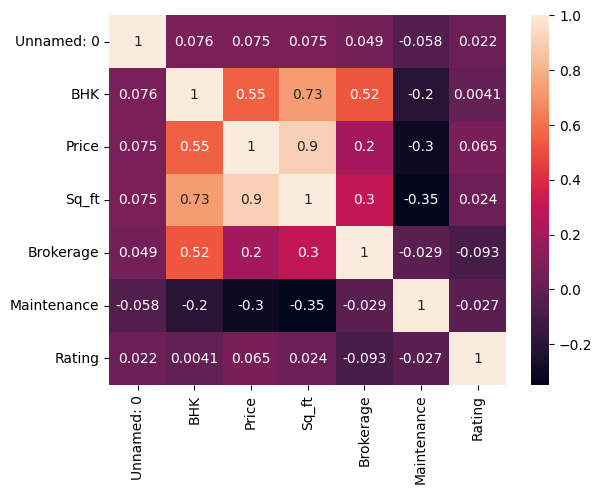

In [42]:
numerical = df.select_dtypes(include=['int','float'])
numerical = numerical.corr()
sns.heatmap(numerical,annot=True)

Price ↔ Sq_ft (0.9) → Strong positive relationship: Bigger houses cost more.
BHK ↔ Sq_ft (0.73) → More bedrooms are usually in bigger houses.
BHK ↔ Price (0.55) → More bedrooms tend to increase price, but size has a bigger influence.
Maintenance ↔ Price (-0.3) → Higher maintenance costs slightly relate to lower prices (possibly due to older properties or less desirable locations).
Rating has very low correlation with price or size → Ratings are probably influenced by other factors.

### What’s the average rent per square foot for each location?

In [59]:
df['per_sqfeet'] = df['Price']/df['Sq_ft']
df.groupby('Location')['per_sqfeet'].mean().reset_index().sort_values(by='per_sqfeet',ascending=False).head(5)

,Location,per_sqfeet
8,Hafeezpet,67.757805
29,Rai Durg,51.172708
33,Shaikpet,47.903085
16,Manchirevula,36.859357
7,Gachibowli,34.337494


C:\Users\palla\AppData\Local\Temp\ipykernel_18868\1540318257.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='per_sqfeet', y='Location', palette='viridis')


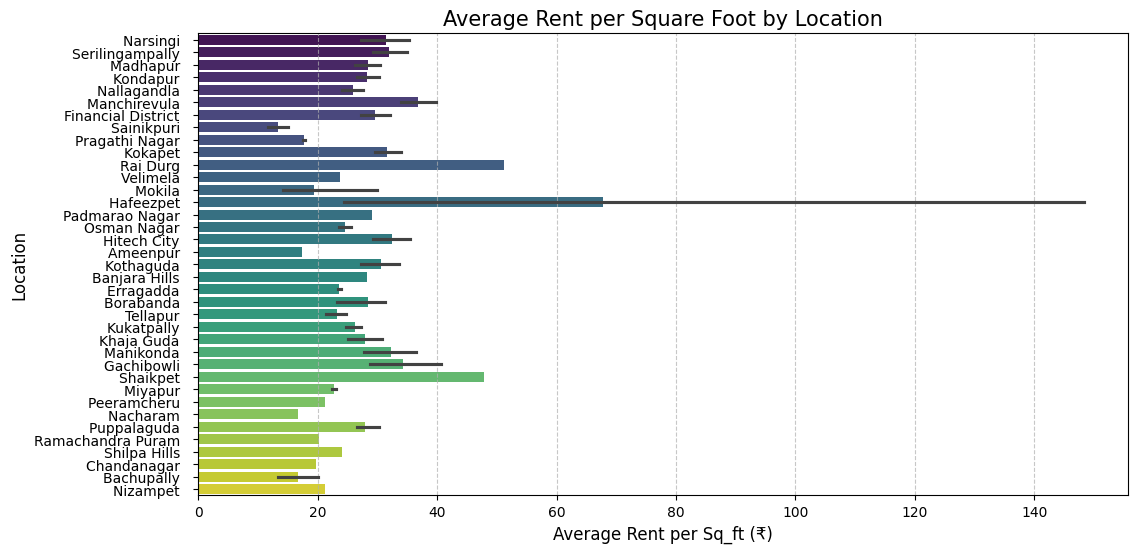

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='per_sqfeet', y='Location', palette='viridis')
plt.title('Average Rent per Square Foot by Location', fontsize=15)
plt.xlabel('Average Rent per Sq_ft (₹)', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### What’s the average rent per square foot for each location?

In [68]:
location_sqft_mode  = df.groupby('Location')['Sq_ft'].agg(lambda x: x.mode().iloc[0]).reset_index()

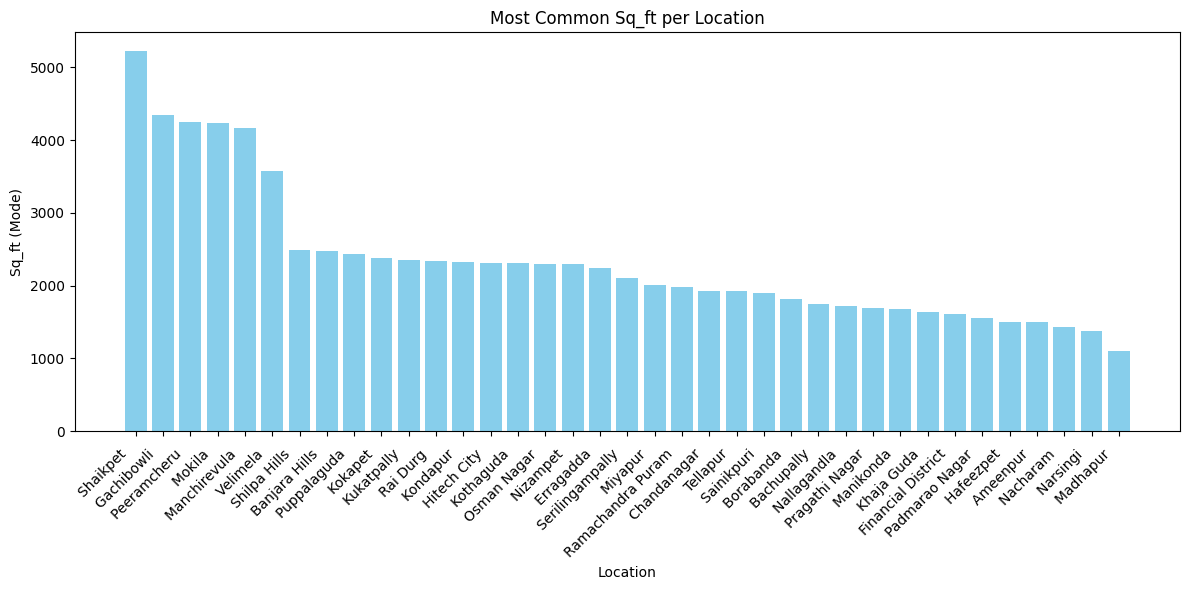

In [71]:
location_sqft_mode = location_sqft_mode.sort_values('Sq_ft', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(location_sqft_mode['Location'], location_sqft_mode['Sq_ft'], color='skyblue')

plt.title('Most Common Sq_ft per Location')
plt.xlabel('Location')
plt.ylabel('Sq_ft (Mode)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Which BHK type is most common overall and in each location?

In [43]:
per_location_common = df.groupby('Location')['BHK'].agg(lambda x: x.value_counts().index[0]).reset_index().head(10)
per_location_common

,Location,BHK
0,Ameenpur,2.0
1,Bachupally,3.0
2,Banjara Hills,3.0
3,Borabanda,3.0
4,Chandanagar,2.5
5,Erragadda,3.0
6,Financial District,3.0
7,Gachibowli,4.0
8,Hafeezpet,2.0
9,Hitech City,3.0


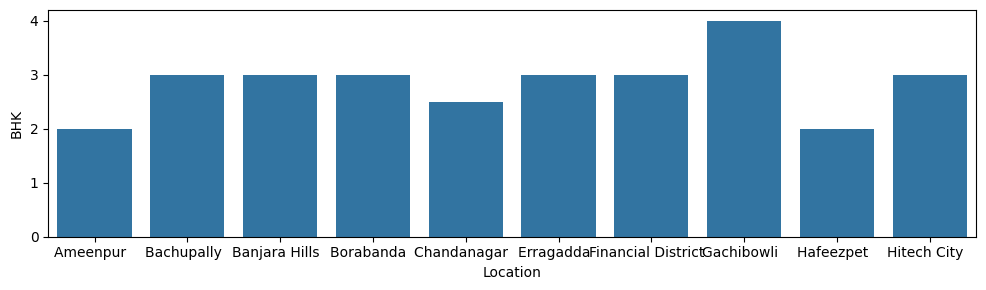

In [51]:
plt.figure(figsize=(10, 3))
sns.barplot(x='Location',y='BHK',data=per_location_common)
plt.tight_layout()
plt.show()

####  What is the average rental price for each BHK category?

In [63]:
avg_price_per_bhk = df.groupby('BHK')['Price'].mean().round(0).reset_index()
avg_price_per_bhk.columns = ['BHK','Average_Rent']
print(avg_price_per_bhk)

   BHK  Average_Rent
0  1.0       21969.0
1  2.0       46408.0
2  2.5       54252.0
3  3.0       61604.0
4  3.5       73200.0
5  4.0      193154.0
6  4.5      137503.0
7  5.0      250000.0


#### boxplot of rental price for each BHK type, with a hue

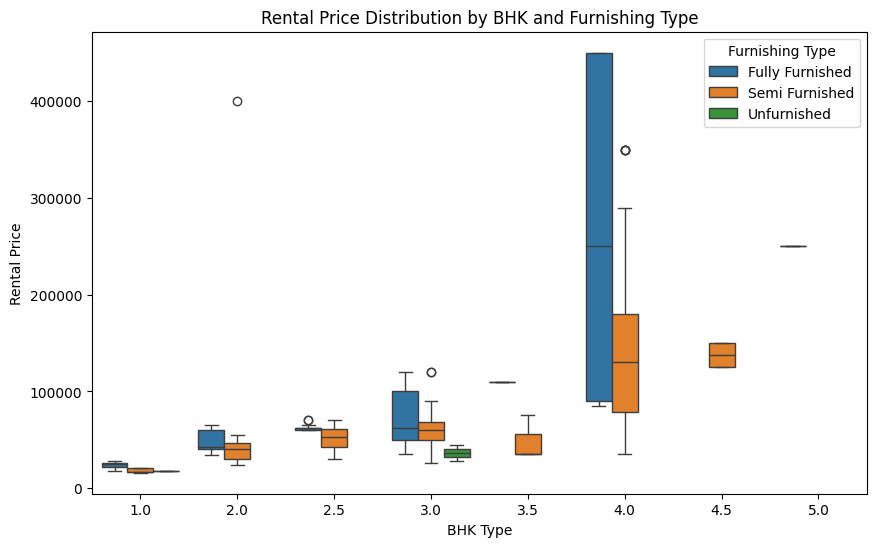

In [66]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='BHK', y='Price', hue='Furnishing')
plt.title("Rental Price Distribution by BHK and Furnishing Type")
plt.xlabel("BHK Type")
plt.ylabel("Rental Price")
plt.legend(title="Furnishing Type")
plt.show()

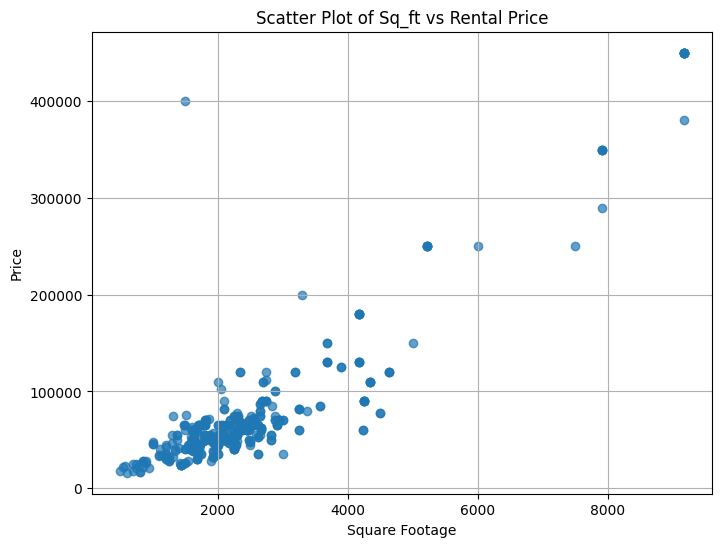

In [87]:
plt.figure(figsize=(8,6))
plt.scatter(df['Sq_ft'], df['Price'], alpha=0.7)
plt.title("Scatter Plot of Sq_ft vs Rental Price")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Positive Relationship
In general, as square footage increases, rental price also increases.
This suggests that bigger houses tend to cost more.
High Price Outliers
A few properties (e.g., ~1500 sq ft costing ₹400k, and 9000+ sq ft costing over ₹450k) are way above the general trend.
These could be luxury apartments, commercial properties, or data entry errors.
Dense Cluster for Small Sizes
Most points are concentrated between 500–2500 sq ft and ₹20k–₹100k.
This means most rentals in your dataset are medium-sized apartments.
Possible Non-linearity
The relationship doesn’t look perfectly linear—price jumps disproportionately for certain large properties.
This may mean size is not the only driver of rent; location, furnishing, or amenities could play a big role.  ##

### Which locations have the highest average price per BHK?

In [105]:
df['Price_per_BHK'] = df['Price'] / df['BHK']

In [120]:
result = df.groupby('Location')['Price_per_BHK'].mean().sort_values(ascending=False).reset_index()
result.head(10)

,Location,Price_per_BHK
0,Shaikpet,62501.550000
1,Hafeezpet,50334.500000
2,Rai Durg,40000.000000
3,Kokapet,39083.721926
4,Manchirevula,38631.684524
5,Gachibowli,26883.333333
6,Hitech City,26806.325253
7,Kothaguda,24668.047619
8,Financial District,24263.756854
9,Banjara Hills,23333.333333


C:\Users\palla\AppData\Local\Temp\ipykernel_50148\3519274879.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bhk_counts.index, y=bhk_counts.values, palette="viridis")


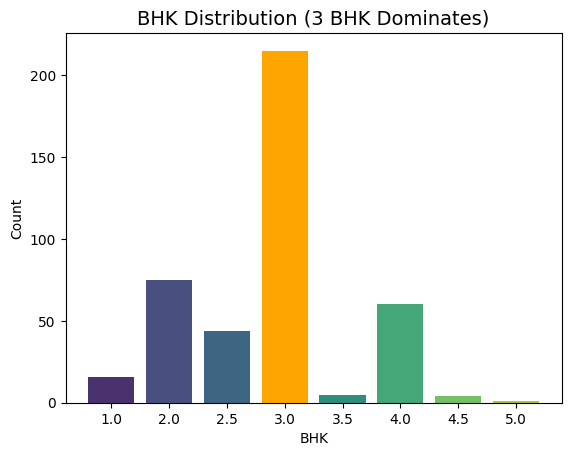

In [134]:
bhk_counts = df['BHK'].value_counts().sort_index()

# Plot
sns.barplot(x=bhk_counts.index, y=bhk_counts.values, palette="viridis")

# Highlight the 3 BHK bar
plt.bar(3, bhk_counts.loc[3.0], color='orange')  # 3.0 is the BHK value

# Labels
plt.title("BHK Distribution (3 BHK Dominates)", fontsize=14)
plt.xlabel("BHK")
plt.ylabel("Count")
plt.show()

### Average amenities count per BHK.

In [180]:
df['Amenities1'] = df['Amenities'].apply(lambda x: len(x.split(',')))
data = df.groupby('BHK')['Amenities1'].mean().reset_index()
data

,BHK,Amenities1
0,1.0,10.750000
1,2.0,12.133333
2,2.5,12.795455
3,3.0,12.553488
4,3.5,13.200000
5,4.0,13.016667
6,4.5,13.000000
7,5.0,14.000000


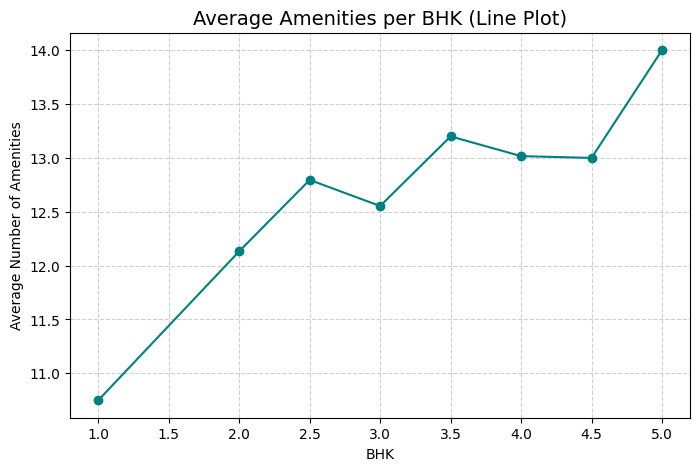

In [189]:
bhk_data = df.groupby('BHK')['Amenities1'].mean().reset_index()

# Line plot
plt.figure(figsize=(8,5))
plt.plot(bhk_data['BHK'], bhk_data['Amenities1'], marker='o', linestyle='-', color='teal')

plt.title("Average Amenities per BHK (Line Plot)", fontsize=14)
plt.xlabel("BHK")
plt.ylabel("Average Number of Amenities")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
numerical_col = df.select_dtypes(include = ['int','float']).columns
numerical_col

Index(['Unnamed: 0', 'BHK', 'Price', 'Sq_ft', 'Brokerage', 'Maintenance',
       'Rating'],
      dtype='object')

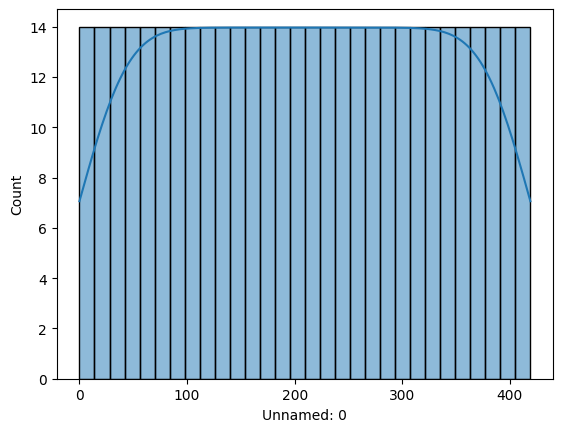

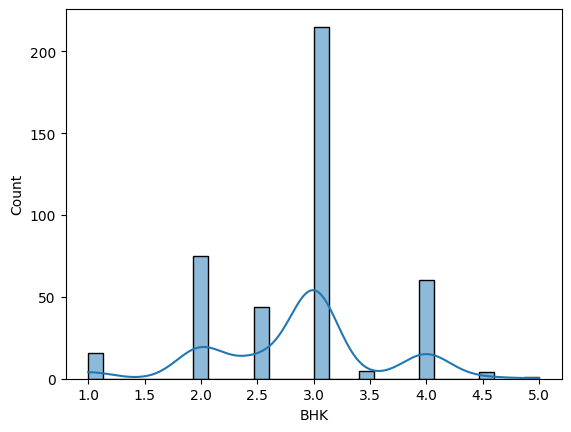

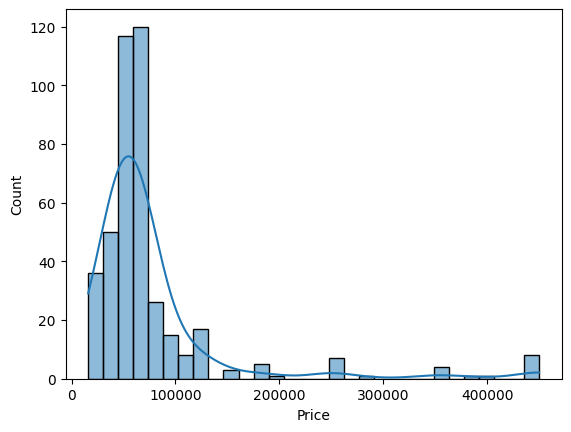

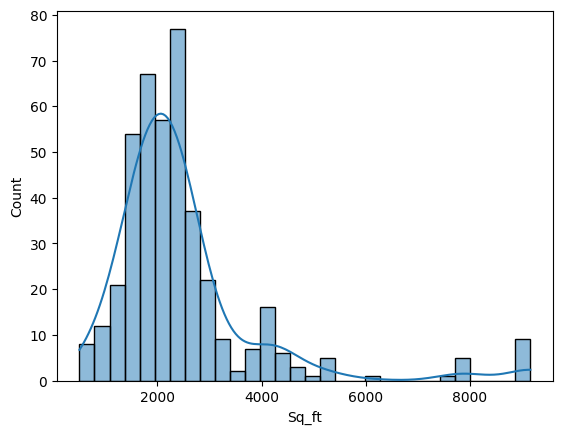

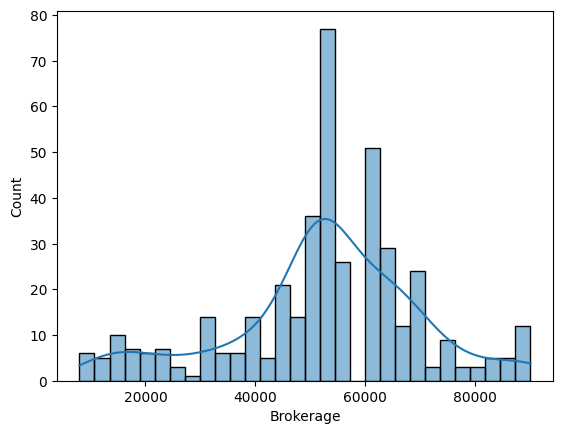

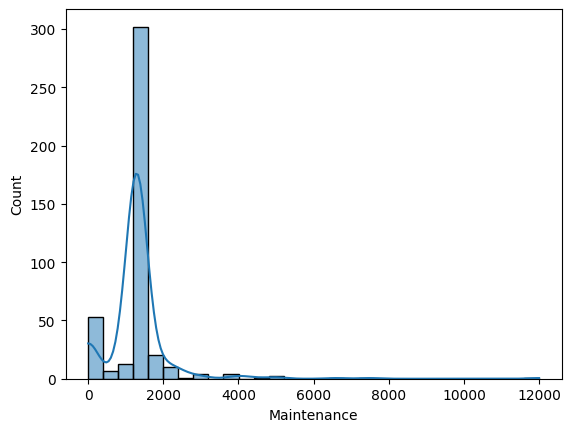

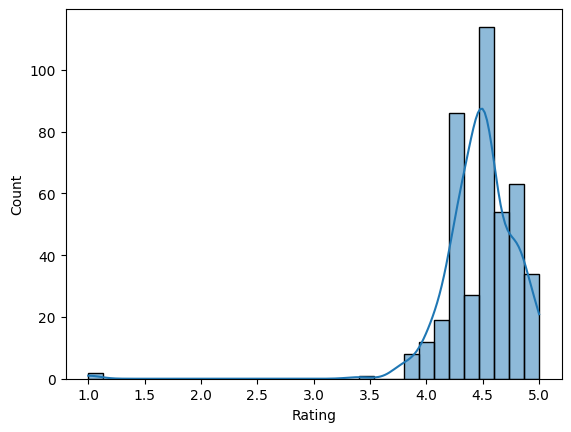

In [10]:
for col in numerical_col:
    sns.histplot(df[col],bins=30,kde=True)
    plt.xlabel(col)
    plt.show()

           Amenity  Count
0             Lift    411
1     Power Backup    395
2         Intercom    389
3              Gym    386
4           Garden    385
5    Swimming Pool    383
6           Sports    381
7           Fridge    288
8              1AC    185
9  Modular Kitchen    183


C:\Users\palla\AppData\Local\Temp\ipykernel_12916\250210869.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=amenity_df.head(10), x='Count', y='Amenity', palette='viridis')


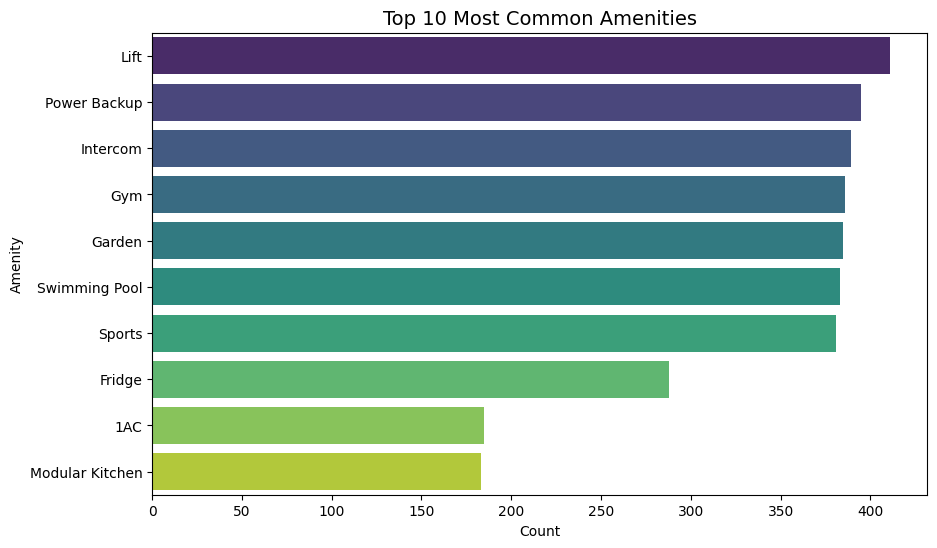

In [42]:
# Split each row's amenities into separate rows
amenity_series = df['Amenities'].str.split(', ').explode()

# Count and sort
amenity_counts_df = amenity_series.value_counts().reset_index()
amenity_counts_df.columns = ['Amenity', 'Count']

print(amenity_counts_df.head(10))
plt.figure(figsize=(10,6))
sns.barplot(data=amenity_df.head(10), x='Count', y='Amenity', palette='viridis')
plt.title("Top 10 Most Common Amenities", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Amenity")
plt.show()

### Compare average prices for Fully Furnished vs Semi Furnished vs Unfurnished houses.

In [77]:
df.groupby('Furnishing')['Price'].mean()

Furnishing
Fully Furnished    111893.021053
Semi Furnished      66764.133540
Unfurnished         30500.000000
Name: Price, dtype: float64

C:\Users\palla\AppData\Local\Temp\ipykernel_12916\3671895041.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Furnishing', y='Price', palette='Set2')


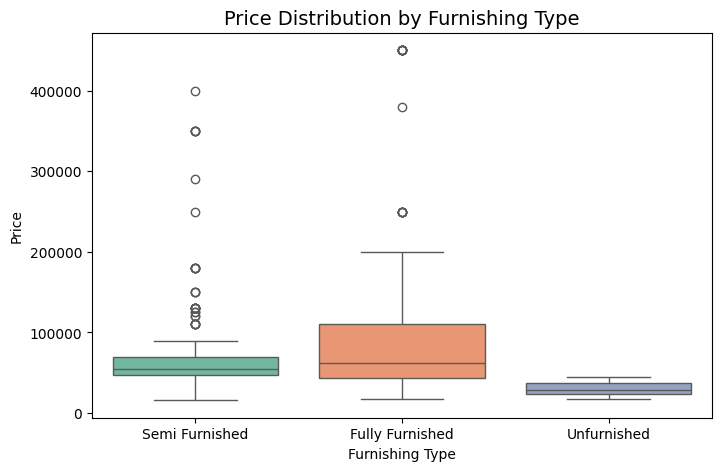

In [78]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Furnishing', y='Price', palette='Set2')
plt.title("Price Distribution by Furnishing Type", fontsize=14)
plt.ylabel("Price")
plt.xlabel("Furnishing Type")
plt.show()

In [88]:
price_comparison

,Has_Swimming_Pool,Price
0,Without Swimming Pool,38770.243243
1,With Swimming Pool,80378.300261


C:\Users\palla\AppData\Local\Temp\ipykernel_12916\1092463427.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Has_Swimming_Pool', y='Price', data=price_comparison, palette='viridis')


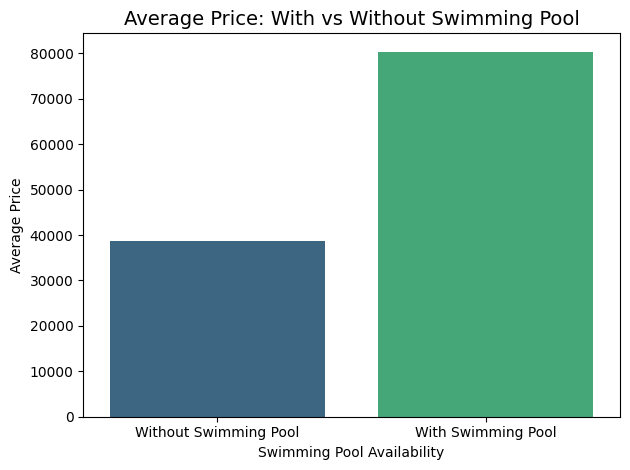

In [94]:
df['Has_Swimming_Pool'] = df['Amenities'].str.contains('Swimming Pool', case=False, na=False)

# Group and get average prices
price_comparison = df.groupby('Has_Swimming_Pool')['Price'].mean().reset_index()

# Rename for clarity
price_comparison['Has_Swimming_Pool'] = price_comparison['Has_Swimming_Pool'].map({True: 'With Swimming Pool', False: 'Without Swimming Pool'})

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Has_Swimming_Pool', y='Price', data=price_comparison, palette='viridis')
plt.title('Average Price: With vs Without Swimming Pool', fontsize=14)
plt.ylabel('Average Price')
plt.xlabel('Swimming Pool Availability')
plt.tight_layout()
plt.show()

In [19]:
df 

,Unnamed: 0,Location,BHK,Price,Amenities,Sq_ft,Brokerage,Maintenance,Rating,Furnishing
0,0,Narsingi,4.0,80000,"Microwave, Stove, Gas Pipeline, Cupboard, 7Fan...",3380,80000.0,1291,4.3,Semi Furnished
1,1,Narsingi,2.0,50003,"Gas Pipeline, Cupboard, 6Fan, 8Light, 2Wardrob...",1370,50003.0,5000,4.5,Semi Furnished
2,2,Serilingampally,2.5,65000,"Gas Pipeline, Cupboard, 6Fan, 36Light, 1Wardro...",1490,32500.0,1291,4.8,Semi Furnished
3,3,Madhapur,2.0,38000,"Washing Machine, Sofa, Stove, Fridge, Water Pu...",1350,38000.0,2000,4.6,Fully Furnished
4,4,Kondapur,1.0,24500,"Washing Machine, Sofa, Fridge, Cupboard, 2Fan,...",750,24500.0,750,4.8,Fully Furnished
...,...,...,...,...,...,...,...,...,...,...
415,415,Kondapur,2.0,30500,"5Fan, 11Light, 2Wardrobe, 1AC, 2Geyser, Chimne...",1250,30500.0,1250,4.8,Semi Furnished
416,416,Kukatpally,3.0,50014,"Dining Table, Washing Machine, Sofa, Microwave...",1813,50014.0,1291,4.3,Fully Furnished
417,417,Manikonda,2.5,62000,"Dining Table, Washing Machine, Sofa, Microwave...",1675,62000.0,1291,4.6,Fully Furnished
418,418,Miyapur,3.0,45011,"Stove, Gas Pipeline, AC, Bed, Pet allowed, Swi...",2013,45011.0,1291,4.6,Semi Furnished
